# Point Cloud Classification

Harsh Patel -- January 2024

A classification model using the princeton point cloud dataset based on a CNN architecture.

Potential Classes:
- chair
- monitor
- dresser
- bathtub
- desk
- bed
- toilet
- table
- night_stand
- sofa

Data credit: http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip

Architecture Diagram:

![Architecture Diagram](https://www.mdpi.com/remotesensing/remotesensing-12-01729/article_deploy/html/images/remotesensing-12-01729-g006.png)


## Setup

Install all needed libraries and connect to colab GPU


In [1]:
!pip install trimesh
!pip install matplotlib
import os
import glob
import trimesh
import matplotlib
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
tf.random.set_seed(99)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 690.0/690.0 kB 6.9 MB/s eta 0:00:00


In [2]:
# Hardware GPU Accelerator
devices = tf.config.experimental.list_physical_devices('GPU')
print("Resources Avaliable: ", len(devices))
tf.config.experimental.set_memory_growth(devices[0], True)

Resources Avaliable:  1


## Download Dataset

Extract dataset from the princeton online source


In [3]:
DATA_DIR = tf.keras.utils.get_file(
    "modelnet.zip",
    "http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip",
    extract=True,
)
DATA_DIR = os.path.join(os.path.dirname(DATA_DIR), "ModelNet10")

473402300/473402300 [==============================] - 12s 0us/step


## Visualize the Data

In [4]:
# Display a 3D mesh of a data point
mesh = trimesh.load(os.path.join(DATA_DIR, "chair/train/chair_0001.off"))
mesh.show()

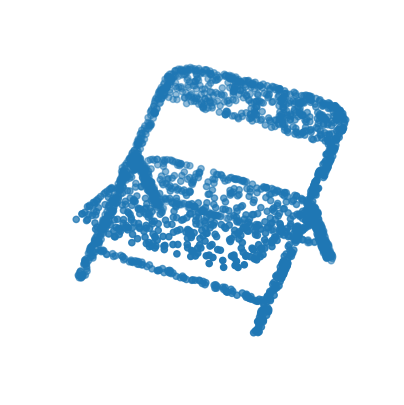

In [5]:
# Display the generated point cloud of the object above
points = mesh.sample(2048)

fig = matplotlib.pyplot.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
ax.set_axis_off()
matplotlib.pyplot.show()

## Parse the Data

Go through each class and organize the data into the appropriate train/test list. The mesh is initally loaded and the generated point cloud data is stored in a numpy array alongside the object label.

In [6]:
# Function to parse dataset into appropriate train and test set
def parse_dataset(num_points=2048):

    train_points = []
    train_labels = []
    test_points = []
    test_labels = []
    class_map = {}
    folders = glob.glob(os.path.join(DATA_DIR, "[!README]*"))

    for i, folder in enumerate(folders):
        print("processing class: {}".format(os.path.basename(folder)))
        # store folder name with ID so we can retrieve later
        class_map[i] = folder.split("/")[-1]
        # gather all files
        train_files = glob.glob(os.path.join(folder, "train/*"))
        test_files = glob.glob(os.path.join(folder, "test/*"))

        for f in train_files:
            train_points.append(trimesh.load(f).sample(num_points))
            train_labels.append(i)

        for f in test_files:
            test_points.append(trimesh.load(f).sample(num_points))
            test_labels.append(i)

    return (
        np.array(train_points),
        np.array(test_points),
        np.array(train_labels),
        np.array(test_labels),
        class_map,
    )

In [7]:
# Call the parse_dataset function to generate the lists of train and split
NUM_POINTS = 2048
NUM_CLASSES = 10
BATCH_SIZE = 32

train_points, test_points, train_labels, test_labels, CLASS_MAP = parse_dataset(NUM_POINTS)

processing class: chair
processing class: monitor
processing class: bathtub
processing class: desk
processing class: bed
processing class: toilet
processing class: table
processing class: night_stand
processing class: sofa


In [8]:
# Augmentation function to randomly shuffle the data for training purposes
def augment(points, label):
    # jitter points
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
    # shuffle points
    points = tf.random.shuffle(points)
    return points, label

# Generate the final training and testing dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_points, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_points, test_labels))

train_dataset = train_dataset.shuffle(len(train_points)).map(augment).batch(BATCH_SIZE)
test_dataset = test_dataset.shuffle(len(test_points)).batch(BATCH_SIZE)

## Build the Model

Using the architecture diagrams build a CNN (Convolutional Neural Networks) as the backbone of the model

In [9]:
# convolutional layers defintion
def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

# dense layers defintion
def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

In [10]:
# Optimizer class defintion
class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))

In [11]:
# Create the tnet using the layer definitons from above
def tnet(inputs, num_features):

    # Initalise bias as the indentity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)

    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    return layers.Dot(axes=(2, 1))([inputs, feat_T])

In [12]:
# Define the layers of the convolutional neural network
inputs = keras.Input(shape=(NUM_POINTS, 3))

x = tnet(inputs, 3)
x = conv_bn(x, 32)
x = conv_bn(x, 32)
x = tnet(x, 32)
x = conv_bn(x, 32)
x = conv_bn(x, 64)
x = conv_bn(x, 512)
x = layers.GlobalMaxPooling1D()(x)
x = dense_bn(x, 256)
x = layers.Dropout(0.3)(x)
x = dense_bn(x, 128)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
# Output the model layer information
model.summary()

Model: "pointnet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 2048, 3)]            0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 2048, 32)             128       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 2048, 32)             128       ['conv1d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 2048, 32)             0         ['batch_normalization[0

## Compile and Train the Model

Using the model defintions from above compile the model, then train the model for a set amount of epochs.

In [13]:
# Model compilation
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)

# Model training
model.fit(train_dataset, epochs=50, validation_data=test_dataset)

Epoch 1/50
125/125 [==============================] - 36s 158ms/step - loss: 3.5346 - sparse_categorical_accuracy: 0.2954 - val_loss: 2706875088896.0000 - val_sparse_categorical_accuracy: 0.2588
Epoch 2/50
125/125 [==============================] - 19s 151ms/step - loss: 2.9194 - sparse_categorical_accuracy: 0.4397 - val_loss: 518979923738624.0000 - val_sparse_categorical_accuracy: 0.4449
Epoch 3/50
125/125 [==============================] - 19s 152ms/step - loss: 2.5113 - sparse_categorical_accuracy: 0.5718 - val_loss: 131641306979149421740032.0000 - val_sparse_categorical_accuracy: 0.4780
Epoch 4/50
125/125 [==============================] - 19s 150ms/step - loss: 2.3251 - sparse_categorical_accuracy: 0.6244 - val_loss: 102911610969855128240128.0000 - val_sparse_categorical_accuracy: 0.4890
Epoch 5/50
125/125 [==============================] - 19s 151ms/step - loss: 2.2604 - sparse_categorical_accuracy: 0.6445 - val_loss: 1687997.1250 - val_sparse_categorical_accuracy: 0.7070
Epoch 6

## Visualize Predictions

Using the testing set look at a series of 8 point clouds with the ground truth label alongside the model prediction.

1/1 [==============================] - 1s 990ms/step


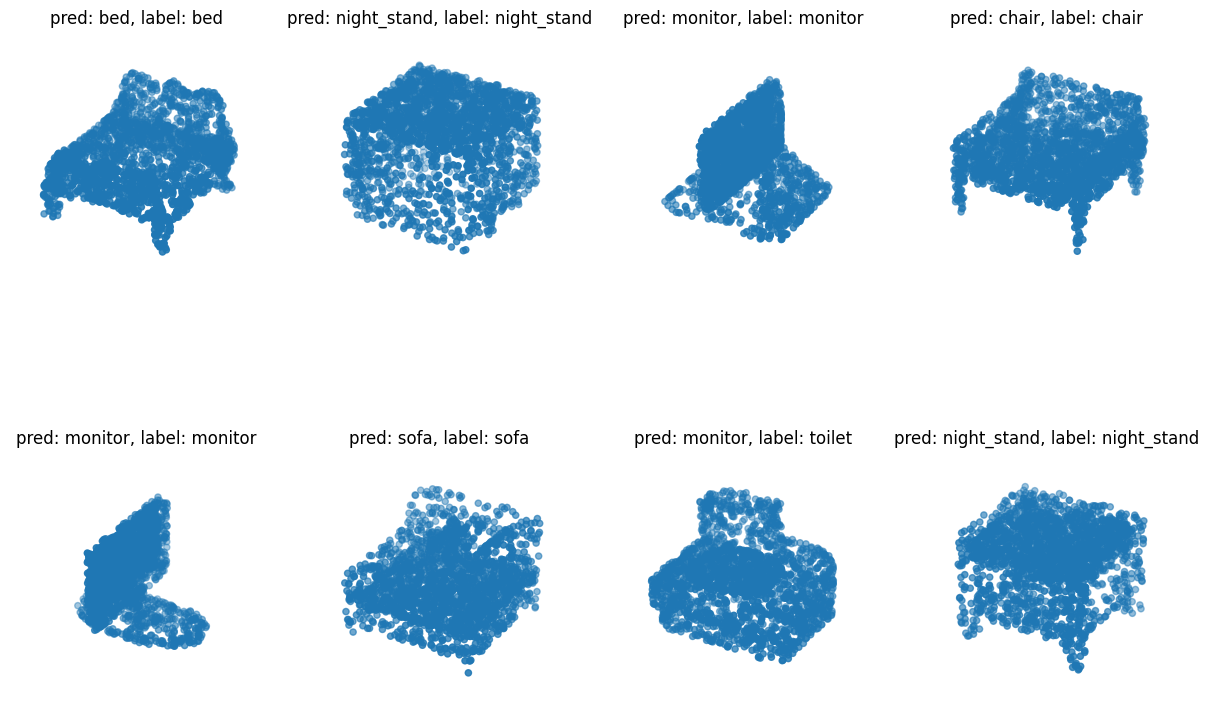

In [14]:
data = test_dataset.take(1)

points, labels = list(data)[0]
points = points[:8, ...]
labels = labels[:8, ...]

# run test data through model
preds = model.predict(points)
preds = tf.math.argmax(preds, -1)

points = points.numpy()

# plot points with predicted class and label
fig = matplotlib.pyplot.figure(figsize=(15, 10))
for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(
            CLASS_MAP[preds[i].numpy()], CLASS_MAP[labels.numpy()[i]]
        )
    )
    ax.set_axis_off()

matplotlib.pyplot.show()